In [1]:
import requests
import pandas as pd

# Define a list of table names and their corresponding API endpoints
tables = {
            
        "Bureau" : 'http://127.0.0.1:5000/bureau',
        "Bureau_balance" : 'http://127.0.0.1:5000/bureau_balance',
        "Credit_card_balance" : 'http://127.0.0.1:5000/credit_card_balance',
        "Installments_payments" : 'http://127.0.0.1:5000/installments_payments',
        "POS_CASH_balance" : 'http://127.0.0.1:5000/pOS_CASH_balance',
        "Previous_application" : 'http://127.0.0.1:5000/previous_application',
        "Application_train" : 'http://127.0.0.1:5000/application_train'
}

# Dictionary to store DataFrames for each table
dataframes = {}

# Make API requests to get data from each table
for table_name, endpoint in tables.items():
    response = requests.get(endpoint)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert API response to a DataFrame and store it in the dictionary
        dataframes[table_name] = pd.DataFrame(response.json())
        print(f"Data for {table_name} fetched successfully.")
    else:
        print(f"Error: Unable to fetch data from {table_name}. Status code: {response.status_code}")

Data for Bureau fetched successfully.
Data for Bureau_balance fetched successfully.
Data for Credit_card_balance fetched successfully.
Data for Installments_payments fetched successfully.
Data for POS_CASH_balance fetched successfully.
Data for Previous_application fetched successfully.
Data for Application_train fetched successfully.


In [2]:
# Merge tables based on specified keys
merged_table = dataframes["Application_train"]

# Merge POS_CASH_balance, Installments_payments, Credit_card_balance based on SK_ID_PREV
for table_name in ["POS_CASH_balance", "Installments_payments", "Credit_card_balance", "Previous_application"]:
    if table_name in dataframes:
        # Specify suffixes to avoid duplicate column names
        merged_table = pd.merge(merged_table, dataframes[table_name], on='SK_ID_CURR', how='left', suffixes=('', f'_{table_name}'))

# Merge Bureau and Bureau_balance based on SK_ID_BUREAU
if "Bureau" in dataframes and "Bureau_balance" in dataframes:
    bureau_merged = pd.merge(dataframes["Bureau"], dataframes["Bureau_balance"], on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bureau_balance'))
    merged_table = pd.merge(merged_table, bureau_merged, on='SK_ID_CURR', how='left')

# Display the final merged table with unique columns
unique_columns = merged_table.columns.unique()
final_table = merged_table[unique_columns]

# Display the final table
print(final_table.head())

   AMT_ANNUITY_x  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0        20128.5    315000.0         315000.0          225000.0   
1        36202.5   1350000.0        1350000.0          135000.0   
2         6750.0    135000.0         135000.0           99000.0   
3         6750.0    135000.0         135000.0           99000.0   
4         6750.0    135000.0         135000.0           99000.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        1.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   


In [3]:
data_df = final_table.drop_duplicates()

In [4]:
data_df=data_df.fillna(0)

In [5]:
data_df['CODE_GENDER'] = data_df['CODE_GENDER'].replace({'F': 0, 'M': 1})

In [6]:
# Changing FLAG_OWN_REALTY AND FLAG_OWN_CAR to 0 and 1 to match model
data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']] = data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']].replace({'Y': 1, 'N': 0}).astype(int)


In [7]:
# Selecting X features
X = data_df.drop(columns=['TARGET'], axis=1)

In [8]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X).astype(int)

In [9]:
y = data_df['TARGET'].values

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[45756     0]
 [ 1463  2276]]

Accuracy: 0.9704414587332054


In [42]:
report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     45756
           1       1.00      0.61      0.76      3739

    accuracy                           0.97     49495
   macro avg       0.98      0.80      0.87     49495
weighted avg       0.97      0.97      0.97     49495



In [15]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels = pd.cut(positive_class_probabilities, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities, 'Risk Level': risk_levels})
result_df.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
# Print the result DataFrame
print(result_df)

       SK_ID_CURR  Probability     Risk Level
0          100003         0.03  Very Low Risk
1          100006         0.10  Very Low Risk
2          100007         0.06  Very Low Risk
3          100009         0.00  Very Low Risk
4          100011         0.03  Very Low Risk
...           ...          ...            ...
36224      456243         0.09  Very Low Risk
36225      456246         0.11  Very Low Risk
36226      456247         0.04  Very Low Risk
36227      456247         0.03  Very Low Risk
36228      456255         0.08  Very Low Risk

[36229 rows x 3 columns]


In [43]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted = importances_sorted[:30]
sorted_df = pd.DataFrame(importances_sorted)
sorted_df[1]

0                             DAYS_BIRTH
1                        DAYS_ID_PUBLISH
2                      DAYS_REGISTRATION
3                 DAYS_LAST_PHONE_CHANGE
4                          AMT_ANNUITY_x
5                             SK_ID_CURR
6                          DAYS_EMPLOYED
7                             AMT_CREDIT
8                       AMT_INCOME_TOTAL
9                        AMT_GOODS_PRICE
10               HOUR_APPR_PROCESS_START
11            AMT_REQ_CREDIT_BUREAU_YEAR
12                           OWN_CAR_AGE
13                           AMT_PAYMENT
14              OBS_60_CNT_SOCIAL_CIRCLE
15                        AMT_INSTALMENT
16              OBS_30_CNT_SOCIAL_CIRCLE
17                    DAYS_ENTRY_PAYMENT
18                       DAYS_INSTALMENT
19                      MONTHS_BALANCE_x
20             CNT_INSTALMENT_MATURE_CUM
21                 CNT_INSTALMENT_FUTURE
22                       CNT_FAM_MEMBERS
23    MONTHS_BALANCE_Credit_card_balance
24              

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

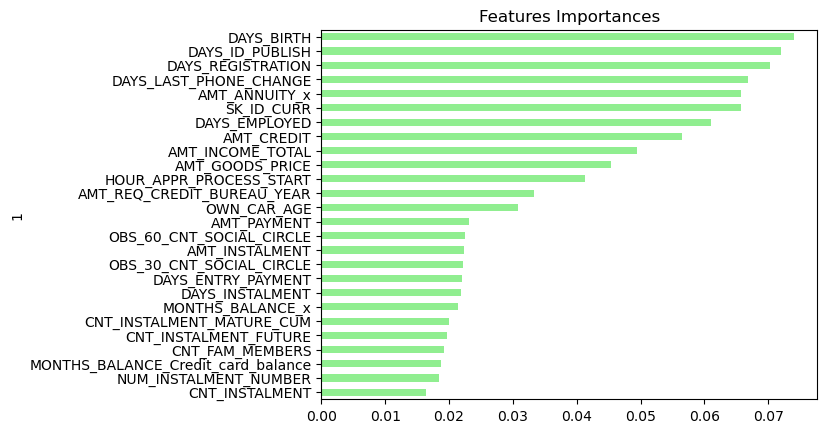

In [44]:
sorted_df.set_index(sorted_df[1], inplace=True)
sorted_df.drop(columns=1, inplace=True)
sorted_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = sorted_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [34]:
X  = data_df[["DAYS_ID_PUBLISH",
                           "DAYS_BIRTH",
                      "DAYS_REGISTRATION",
                 "DAYS_LAST_PHONE_CHANGE",
                          "AMT_ANNUITY_x",
                             "SK_ID_CURR",
                             "AMT_CREDIT",
                          "DAYS_EMPLOYED",
                        "AMT_GOODS_PRICE",
                       "AMT_INCOME_TOTAL",
               "HOUR_APPR_PROCESS_START",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
                           "OWN_CAR_AGE",
              "OBS_30_CNT_SOCIAL_CIRCLE",
              "OBS_60_CNT_SOCIAL_CIRCLE",
                           "AMT_PAYMENT",
                    "DAYS_ENTRY_PAYMENT",
                        "AMT_INSTALMENT",
                       "DAYS_INSTALMENT",
                 "NUM_INSTALMENT_NUMBER",
                 "CNT_INSTALMENT_FUTURE",
                      "MONTHS_BALANCE_x",
                       "CNT_FAM_MEMBERS",
                        "CNT_INSTALMENT",
             "CNT_INSTALMENT_MATURE_CUM",
    "MONTHS_BALANCE_Credit_card_balance"]]

In [35]:
X = X.fillna(0)

In [36]:
y = data_df['TARGET']

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[45756     0]
 [ 1463  2276]]

Accuracy: 0.9704414587332054


In [39]:
report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     45756
           1       1.00      0.61      0.76      3739

    accuracy                           0.97     49495
   macro avg       0.98      0.80      0.87     49495
weighted avg       0.97      0.97      0.97     49495



In [70]:
import joblib
joblib.dump(model, 'model_probability.joblib')

['model_probability.joblib']

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming you have a dataset with features (X) and pricing target variable (y)
# Replace X, y with your actual dataset

# Generate some sample data
np.random.seed(42)
X = np.random.rand(100, 5)
y = 3 * X[:, 0] + 2 * X[:, 1] - X[:, 2] + np.random.randn(100) * 0.1  # Sample pricing

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict with Random Forest
rf_predictions = rf_model.predict(X_test_scaled)

# Calculate RMSE for Random Forest
rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse}")

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
xgb_predictions = xgb_model.predict(X_test)

# Calculate RMSE for XGBoost
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost RMSE: {xgb_rmse}")


Random Forest RMSE: 0.21798580636574888
XGBoost RMSE: 0.2898705546802953


In [65]:
X = data_df[["DAYS_ID_PUBLISH", "DAYS_BIRTH", "DAYS_REGISTRATION", "DAYS_LAST_PHONE_CHANGE",
              "AMT_ANNUITY_x", "SK_ID_CURR", "DAYS_EMPLOYED", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL",
              "HOUR_APPR_PROCESS_START", "AMT_REQ_CREDIT_BUREAU_YEAR", "OWN_CAR_AGE",
              "OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "AMT_PAYMENT",
              "DAYS_ENTRY_PAYMENT", "AMT_INSTALMENT", "DAYS_INSTALMENT", "NUM_INSTALMENT_NUMBER",
              "CNT_INSTALMENT_FUTURE", "MONTHS_BALANCE_x", "CNT_FAM_MEMBERS", "CNT_INSTALMENT",
              "CNT_INSTALMENT_MATURE_CUM", "MONTHS_BALANCE_Credit_card_balance"]]

In [66]:
y = data_df["AMT_CREDIT"]

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler and transform the data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Convert categorical columns to dummy variables
X_train_dummy = pd.get_dummies(X_train_scaled).astype(int)
X_test_dummy = pd.get_dummies(X_test_scaled).astype(int)

# Train a RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_dummy, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test_dummy)



In [69]:
# Create a DataFrame with actual and predicted values
result_df = pd.DataFrame({'Actual Values': y_test.astype(int), 'Predicted Prices': predictions.astype(int)}).reset_index(drop=True)

# Display the result DataFrame without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(result_df)

       Actual Values  Predicted Prices
0              57564             90304
1            1236816           1239745
2             755190            755190
3             112068            112403
4             599472            774630
...              ...               ...
49490         180000            197196
49491         450000            439352
49492         834048            834048
49493         254700            576114
49494         474048            423018

[49495 rows x 2 columns]


In [71]:
# Prediction model for joblib dump
joblib.dump(model, 'model_amount.joblib')

['model_amount.joblib']